### Using Multiple State Schemas in LangGraph

#### Overview

This demo demonstrates how to use **multiple state schemas** within a LangGraph workflow. This approach allows separating "visible" state from "hidden" internal state, and supports modular processing pipelines with distinct input, process, and output stages.

In [10]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

#### **First Approach: Hidden Layer State**


In [11]:
class ProcessState(TypedDict):
    input: str
    output: str

In [12]:
class HiddenState(TypedDict):
    thought: str

In [13]:
def node_a(state: ProcessState) -> HiddenState:
    input_value = state["input"]
    print(f"NODE A:\n "
        f"->input:{input_value}\n " 
    )
    return {"thought": f"I don't know what to do with with this message"}

def node_b(state: HiddenState) -> ProcessState:
    hidden_thought = state["thought"]
    print(f"NODE B:\n "
        f"->hidden_thought:{hidden_thought}\n " 
    )
    return {"output": "Thank you for your message! We're processing it and get back to you soon!"}

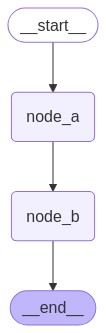

In [14]:
workflow = StateGraph(ProcessState)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [15]:
graph.invoke({"input" : "The product doesn't work. I want my money back!"})

NODE A:
 ->input:The product doesn't work. I want my money back!
 
NODE B:
 ->hidden_thought:I don't know what to do with with this message
 


{'input': "The product doesn't work. I want my money back!",
 'output': "Thank you for your message! We're processing it and get back to you soon!"}

#### **Second Approach: Input-Process-Output State Separation**

In [16]:
class InputState(TypedDict):
    input: str

class OutputState(TypedDict):
    output: str

class ProcessState(TypedDict):
    input: str
    thought: str
    output: str

In [17]:
def l1_agent(state: InputState):
    input_value = state["input"]
    print(f"NODE A:\n "
        f"->input:{input_value}\n " 
    )
    return {
        "output": "Thank you for your message!",
        "thought": "An L2 Agent should take care of this"
    }

def l2_agent(state: ProcessState) -> OutputState:
    l1_output = state["output"]
    hidden_thought = state["thought"]
    print(f"NODE B:\n "
        f"->l1_output:{l1_output}\n "
        f"->hidden_thought:{hidden_thought}\n " 
    )
    return {
        "output": f"{l1_output} We're processing it and get back to you soon!"
    }

In [19]:
# workflow = StateGraph(ProcessState)
workflow = StateGraph(ProcessState, input=InputState, output=OutputState)
workflow.add_node(l1_agent)
workflow.add_node(l2_agent)
workflow.add_edge(START, "l1_agent")
workflow.add_edge("l1_agent", "l2_agent")
workflow.add_edge("l2_agent", END)
graph = workflow.compile()

In [20]:
graph.invoke({"input" : "The product doesn't work. I want my money back!"})

NODE A:
 ->input:The product doesn't work. I want my money back!
 
NODE B:
 ->l1_output:Thank you for your message!
 ->hidden_thought:An L2 Agent should take care of this
 


{'output': "Thank you for your message! We're processing it and get back to you soon!"}

#### **Conclusion**

- LangGraph’s support for multiple state schemas enables building structured, multi-phase workflows.
- Using hidden or separated states improves system safety, transparency, and modularity.
- This pattern is particularly useful for agent design where reasoning must be separated from final user communication.